In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import os
from typing import Tuple

In [2]:
path_images = r'C:\TRABAJO\Willdom\Sr Machine Learning Engineer\Challenge'
# path_images = r'C:\TRABAJO\Willdom\Sr Machine Learning Engineer\ordenes medicas'
working_resolution = [512, 512]
vocabulary_size = 64

# Helper functions

In [3]:
# Helper functions
def load_images_from_folder(folder: str, resolution: list) -> list:
    images = {}
    for filename in os.listdir(folder):
        if filename.split('.')[-1] == 'jpg':
            path = os.path.join(folder, filename)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, resolution)
            if img is not None:
                images[filename] = img
    return images

def sift_dictionary(images: dict) -> list:
    """Create a dictionary of descriptors with SIFT."""
    sift = cv2.SIFT_create()
    visual_dictionary = []
    descriptors_by_image = {}
    for name, img in images.items():
        kp, des = sift.detectAndCompute(img, None)
        # print(f'image {name} has {len(des)} descriptors')
        visual_dictionary.extend(des)
        descriptors_by_image[name] = des
    return visual_dictionary, descriptors_by_image

def kmeans_visual_vocabulary(k: int, visual_dictionary: list) -> Tuple:
    """Create a vocabulary with k-means quantization."""
    kmeans = KMeans(n_init=10, n_clusters=64)
    kmeans.fit(visual_dictionary)
    visual_words = kmeans.cluster_centers_
    word_classifier = lambda x: kmeans.predict(np.array(x, dtype='float')) 
    return visual_words, word_classifier

def get_words_by_image(descriptors_by_image: dict, word_classifier) -> dict:
    """Get the visual words in each image by using kmeans predictor."""
    words_by_image = {}
    for name, descriptors in descriptors_by_image.items():
        words_by_image[name] = word_classifier(descriptors)
    return words_by_image

def get_global_descriptor_by_image(words_by_image: dict, vocabulary_size: int) -> Tuple[dict, np.array]:
    """Create a histogram of visual words for each image"""
    global_descriptor_by_image = {}
    for name, words in words_by_image.items():
        global_descriptor_by_image[name] = np.array(
            np.histogram(words, range=(-.5,vocabulary_size+.5), bins=vocabulary_size)[0],
        dtype='float32')

    # global_descriptor_by_image to array of descriptors
    global_descriptors = np.zeros((len(words_by_image), vocabulary_size), 
                                    dtype=global_descriptor_by_image[list(global_descriptor_by_image.keys())[0]].dtype)
    i = 0
    for name, global_descriptor in global_descriptor_by_image.items():
        global_descriptors[i, :] = global_descriptor_by_image[name]
        i += 1

    return global_descriptor_by_image, global_descriptors

# Class definition

In [4]:
class ImageRetriever:
    def __init__(self, working_resolution: list = None, vocabulary_size: int = 64) -> None:
        self.working_resolution = [512, 512] if working_resolution is None else working_resolution
        assert len(self.working_resolution) == 2
        assert isinstance(vocabulary_size, int) and vocabulary_size > 2
        self.vocabulary_size = vocabulary_size

        self.images = None
        self.visual_dictionary = None
        self.descriptors_by_image = None
        self.visual_words = None
        self.word_classifier = None
        self.words_by_image = None
        self.global_descriptor_by_image = None
        self.global_descriptors = None

    def fit(self, folder_path: str):     
        # Processing
        print('Loading images...')        
        self.images = load_images_from_folder(folder_path, self.working_resolution)
        print(f'{len(self.images)} images were loaded')

        print('Extracting local descriptors from the images...')   
        self.visual_dictionary, self.descriptors_by_image = sift_dictionary(self.images)
        print(f'The visual dictionary has {len(self.visual_dictionary)} local descriptors')

        print('Clustering local descriptors... This takes some minutes...')
        self.visual_words, self.word_classifier = kmeans_visual_vocabulary(self.vocabulary_size, self.visual_dictionary)
        print(f'The visual vocabulary has {len(self.visual_words)} visual words')

        print('Estracting visual words from the image local descriptors...')
        self.words_by_image = get_words_by_image(self.descriptors_by_image, self.word_classifier)
        print('The visual words of each image are ready.')

        print("Computing a global descriptor for each image...")
        self.global_descriptor_by_image, self.global_descriptors = get_global_descriptor_by_image(self.words_by_image, self.vocabulary_size)
        print("The global descriptors of each image are ready.")

    def retrieve_from_training_set(self, query_image_name: str, result_size: int = 3,
                                   display_image_results: bool = True) -> (list, list):
        # Create a matcher
        bf = cv2.FlannBasedMatcher()

        # Match descriptors
        matches = bf.knnMatch(self.global_descriptor_by_image[query_image_name].reshape((1, -1)), 
                              self.global_descriptors, k=result_size)[0]
        matches_idx = [match.trainIdx for match in matches]
        print(matches_idx)
        matches_names = [list(self.images.keys())[i] for i in matches_idx]
        print(matches_names)

        if display_image_results:
            for i in range(result_size):
                name = matches_names[i]
                cv2.imshow(f'Query result: {name} - Distance: {matches[i].distance}', cv2.resize(cv2.imread(name), working_resolution))
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        
        return matches_names, matches
    
    def retrieve_from_file(self, filename: str, result_size: int = 3,
                           display_image_results: bool = True) -> (list, list):
        # load query image
        assert filename.split('.')[-1] == 'jpg'
        query_image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        query_image = cv2.resize(query_image, self.working_resolution)
        query_image_name = filename
        query_images = {query_image_name: query_image}

        cv2.imshow('Query image', query_image)

        # Get global descriptor of query_image
        _, descriptors_in_query_image = sift_dictionary(query_images)
        words_in_query_image = get_words_by_image(descriptors_in_query_image, self.word_classifier)
        _, global_descriptor_of_query_image = get_global_descriptor_by_image(words_in_query_image, self.vocabulary_size)

        # Create a matcher
        bf = cv2.FlannBasedMatcher()

        # Match descriptors
        matches = bf.knnMatch(global_descriptor_of_query_image, 
                              self.global_descriptors, k=result_size)[0]
        matches_idx = [match.trainIdx for match in matches]
        print(matches_idx)
        matches_names = [list(self.images.keys())[i] for i in matches_idx]
        print(matches_names)

        if display_image_results:
            for i in range(result_size):
                name = matches_names[i]
                cv2.imshow(f'Query result: {name} - Distance: {matches[i].distance}', 
                           cv2.resize(self.images[name], working_resolution))
            cv2.waitKey(0)
        
        cv2.destroyAllWindows()
        
        return matches_names, matches

    def display_images(self):
        if self.images is not None:
            cv2.namedWindow('image', cv2.WINDOW_GUI_EXPANDED)
            for filename in self.images.keys():
                cv2.imshow('image', self.images[filename])
                cv2.waitKey(0)
            cv2.destroyAllWindows()
        else:
            print('Images not loaded, use .fit()')
            

# Training

In [5]:
ir = ImageRetriever()

ir.fit(path_images)
ir.display_images()

Loading images...


28 images were loaded
Extracting local descriptors from the images...
The visual dictionary has 38095 local descriptors
Clustering local descriptors... This takes some minutes...
The visual vocabulary has 64 visual words
Estracting visual words from the image local descriptors...
The visual words of each image are ready.
Computing a global descriptor for each image...
The global descriptors of each image are ready.


# Test

## On an image included in the training set

In [6]:
# matches_names, matches = ir.retrieve_from_training_set('IMG_20220203_152013349.jpg', result_size=10)


## On an unseen image

[3, 7, 8, 12, 11, 10, 9, 22, 23, 4]
['IMG_20220203_152013349.jpg', 'IMG_20220214_134233140.jpg', 'IMG_20220214_144907525.jpg', 'IMG_20220216_171549908.jpg', 'IMG_20220216_145949270.jpg', 'IMG_20220216_143433424.jpg', 'IMG_20220215_144642554.jpg', 'IMG_20231217_222533482.jpg', 'IMG_20231217_222547646_HDR.jpg', 'IMG_20220203_155830590.jpg']


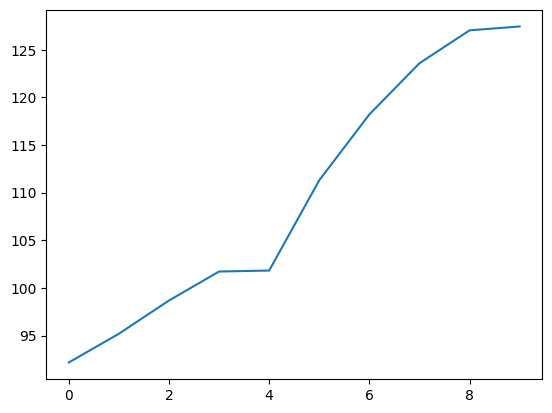

In [12]:
matches_names, matches = ir.retrieve_from_file(
    r'C:\TRABAJO\Willdom\Sr Machine Learning Engineer\Challenge\query images\IMG_20220214_124603956.jpg', 
                      result_size=10)

# matches_names, matches = ir.retrieve_from_file(r'C:\TRABAJO\Willdom\Sr Machine Learning Engineer\ordenes medicas\query image\IMG_20231212_231756467.jpg', 
#                       result_size=10)


distances = [_.distance for _ in matches]
plt.plot(distances)